# TODO: bring back i<=j and phi<=psi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
orbitals = {
    'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'gthszvmolopt': {6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]}
}

In [5]:
device = 'cpu'

In [ ]:
def swap_orbital_order(
    matrix: Union[torch.tensor, np.ndarray],
    frames: Union[List, ase.Atoms],
    orbital: dict,
):
    """Fix the l=1 matrix components from [x,y,z] to [-1, 0,1], handles single and multiple frames"""

    def fix_one_matrix(
        matrix: Union[torch.tensor, np.ndarray], frame: ase.Atoms, orbital: dict
    ):
        idx = []
        iorb = 0
        atoms = list(frame.numbers)
        for atom_type in atoms:
            cur = ()
            for _, a in enumerate(orbital[atom_type]):
                n, l, _ = a
                if (n, l) != cur:
                    if l == 1:
                        idx += [iorb + 1, iorb + 2, iorb]
                    else:
                        idx += range(iorb, iorb + 2 * l + 1)
                    iorb += 2 * l + 1
                    cur = (n, l)
        return matrix[idx][:, idx]

    if isinstance(frames, list):
        assert len(matrix.shape) == 3  # (nframe, nao, nao)
        fixed_matrices = []
        for i, f in enumerate(frames):
            fixed_matrices.append(fix_one_matrix(matrix[i], f, orbital))
        if isinstance(matrix, np.ndarray):
            return np.asarray(fixed_matrices)
        return torch.stack(fixed_matrices)
    else:
        return fix_one_matrix(matrix, frames, orbital)

In [898]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
# ORBS = 'gthszvmolopt'
START = 0
STOP = 1
# frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
frames = read(f'{root}/c2/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True] 

# kmesh = [15,15,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/fock_{i}.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/overlap_{i}.npy") for i in range(START, STOP)]

kmesh = [8,8,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/c2/fock_{i}_881.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/c2/over_{i}_881.npy") for i in range(START, STOP)]
kfock = [np.load(f"{root}/c2/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/c2/over_{i}_881.npy") for i in range(START, STOP)]


# kmesh = [12,12,1]
# kmesh = [1,1,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/graphene_supercell_variety/cp2k/fock_{i-1}.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/graphene_supercell_variety/cp2k/overlap_{i-1}.npy") for i in range(START, STOP)]

for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

# for ifr in range(len(frames)):
#     line = np.concatenate([cs_phase[ORBS][s] for s in frames[ifr].numbers])
#     cs = np.outer(line, line)
#     for ik in range(len(kfock[ifr])):
#         kfock[ifr][ik] = kfock[ifr][ik]*cs
#         kover[ifr][ik] = kover[ifr][ik]*cs

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, dimension = 2,
                               fock_kspace = [kfock[ifr][:] for ifr in range(len(frames))], 
                               overlap_kspace = [kover[ifr][:] for ifr in range(len(frames))],
                               device = device, orbs = orbitals[ORBS], orbs_name = ORBS)
# dataset_o = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = [kover[ifr][:] for ifr in range(len(frames))] , device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [6]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 1
STOP = 2
frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True] 

kmesh = [8,8,1]
kfock = [np.load(f"{root}/graphene_supercell_variety/fock_hex_881.npy")]
kover = [np.load(f"{root}/graphene_supercell_variety/over_hex_881.npy")]

for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, dimension = 2,
                               fock_kspace = [kfock[ifr][:] for ifr in range(len(frames))], 
                               overlap_kspace = [kover[ifr][:] for ifr in range(len(frames))],
                               device = device, orbs = orbitals[ORBS], orbs_name = ORBS)

In [438]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 5
frames = read(f'{root}/c2/cp2k/sto-3g/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True]

kmesh = [15,15,1]
kfock = [np.load(f"{root}/c2/cp2k/sto-3g/fock_{i}.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/c2/cp2k/sto-3g/overlap_{i}.npy") for i in range(START, STOP)]

# for ifr in range(len(frames)):
#     for ik, k in enumerate(kfock[ifr]):
#         kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
#         kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset_cp2k = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, 
                               dimension = 2,
                               fock_kspace = [kfock[ifr][:] for ifr in range(len(frames))], 
                               overlap_kspace = [kover[ifr][:] for ifr in range(len(frames))],
                               device = device, orbs = orbitals[ORBS], orbs_name = ORBS)

In [586]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 1
frames = read(f'{root}/c2/cp2k/different_kmesh/graphene.xyz', slice(0, 1))
for f in frames: 
    f.pbc = [True, True, True]

kmesh = [9,9,1]
kfock = [np.load(f"{root}/c2/cp2k/different_kmesh/sto-3g/fock_{i}.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/c2/cp2k/different_kmesh/sto-3g/overlap_{i}.npy") for i in range(START, STOP)]

# for ifr in range(len(frames)):
#     for ik, k in enumerate(kfock[ifr]):
#         kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
#         kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset_cp2k = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, 
                                    dimension = 2,
                                    fock_kspace = [kfock[ifr][:] for ifr in range(len(frames))], 
                                    overlap_kspace = [kover[ifr][:] for ifr in range(len(frames))],
                                    device = device, orbs = orbitals[ORBS], orbs_name = ORBS)

In [588]:
cutoff = 10
target_blocks, target_coupled_blocks = get_targets(dataset_cp2k, cutoff = cutoff, device = device)
HT_cp2k = blocks_to_matrix(target_blocks, dataset_cp2k)

target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)
HT_pyscf = blocks_to_matrix(target_blocks, dataset)

In [618]:
def matrix_norm(T, matrix, frame, nao):
    from skimage.util import view_as_blocks
    blocks = view_as_blocks(matrix.numpy(), (nao, nao))
    dist = []
    norms = []
    natm = frame.get_global_number_of_atoms()
    for i in range(natm):
        for j in range(natm):
            rij = np.linalg.norm(frame.cell.T.dot(T) + frame.positions[j] - frame.positions[i])
            Hij = np.linalg.norm(blocks[i, j])
            dist.append(rij)
            norms.append(Hij)
    return np.array(dist).reshape(natm, natm), np.array(norms).reshape(natm, natm)

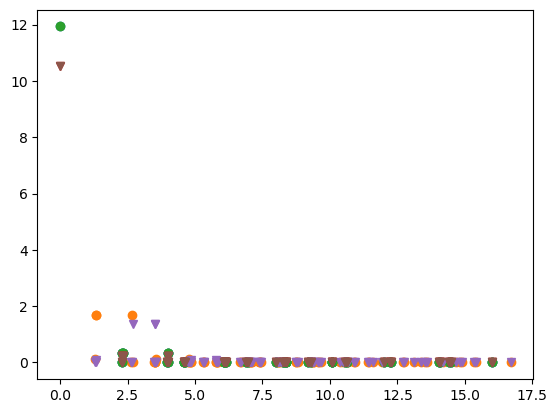

In [636]:
fig, ax = plt.subplots()

n1 = np.array([matrix_norm(T, HT_pyscf[0][T], frame, 5) for T in HT_pyscf[0]])
x = n1[:, 0]
y = n1[:, 1]
for i in range(2):
    for j in range(i, 2):
        ax.plot(x[:,i,j], y[:,i,j], 'o')

n1 = np.array([matrix_norm(T, HT_cp2k[0][T], frame, 5) for T in HT_cp2k[0]])
x = n1[:, 0]
y = n1[:, 1]
for i in range(2):
    for j in range(i, 2):
        ax.plot(x[:,i,j], y[:,i,j], 'v')

In [886]:
torch.norm(pred_H[0][0,0,0] - pred_H[0][0,0,0].T)

tensor(65.6060, grad_fn=<LinalgVectorNormBackward0>)

In [1061]:
for k, b in target_blocks.items():
    ni, li, nj, lj = k['n_i'], k['l_i'], k['n_j'], k['l_j']
    bt = k['block_type']
    if True:
        new_k = Labels(k.names, np.array([[bt, 6, nj, lj, 6, ni, li]]))
        print(new_k)
        new_b = target_blocks.block(new_k)
        for iss, s in enumerate(b.samples):
            i, j = s['center'], s['neighbor']
            if s['cell_shift_a'] == 0 and s['cell_shift_b'] == 0 and s['cell_shift_c'] == 0:
                if i == j:
                    continue
                # print(i,j)
                idx = np.where(np.all(new_b.samples.values[:,1:] == np.array([j, i, 0, 0, 0]), axis = 1))
                # print(idx[0])
                print(torch.norm(new_b.values[idx[0]] - b.values[iss]))

Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        1           6       1    0       6       1    0
)
tensor(0.)
tensor(0.)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        -1          6       1    0       6       1    0
)
tensor(0.)
tensor(0.)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        1           6       2    0       6       1    0
)
tensor(0.)
tensor(0.)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        -1          6       2    0       6       1    0
)
tensor(0.)
tensor(0.)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        1           6       2    1       6       1    0
)
tensor(1.0875e-13)
tensor(1.0875e-13)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        -1          6       2    1       6       1    0
)
tensor(2.4520)
tensor(2.4520)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        1           6       1    0       

In [1063]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
pred = _to_uncoupled_basis(model())
for k, b in pred.items():
    ni, li, nj, lj = k['n_i'], k['l_i'], k['n_j'], k['l_j']
    bt = k['block_type']
    if True:
        new_k = Labels(k.names, np.array([[bt, 6, nj, lj, 6, ni, li]]))
        print(new_k)
        new_b = pred.block(new_k)
        for iss, s in enumerate(b.samples):
            i, j = s['center'], s['neighbor']
            if s['cell_shift_a'] == 0 and s['cell_shift_b'] == 0 and s['cell_shift_c'] == 0:
                if i == j:
                    continue
                # print(i,j)
                idx = np.where(np.all(new_b.samples.values[:,1:] == np.array([j, i, 0, 0, 0]), axis = 1))
                # print(idx[0])
                print(torch.norm(new_b.values[idx[0]] - b.values[iss]))

Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        1           6       1    0       6       1    0
)
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        -1          6       1    0       6       1    0
)
tensor(5.6320e-16, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.6320e-16, grad_fn=<LinalgVectorNormBackward0>)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        1           6       2    0       6       1    0
)
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
tensor(0., grad_fn=<LinalgVectorNormBackward0>)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        -1          6       2    0       6       1    0
)
tensor(5.6320e-16, grad_fn=<LinalgVectorNormBackward0>)
tensor(5.6320e-16, grad_fn=<LinalgVectorNormBackward0>)
Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j
        1           6      

In [885]:
for T in pred_H[0]:
    mT = tuple(-t for t in T)
    print(torch.norm(pred_H[0][T] - pred_H[0][mT].T))

for T in targ_H[0]:
    mT = tuple(-t for t in T)
    print(torch.norm(targ_H[0][T] - targ_H[0][mT].T))

tensor(7.9826, grad_fn=<LinalgVectorNormBackward0>)
tensor(11.2057, grad_fn=<LinalgVectorNormBackward0>)
tensor(22.6357, grad_fn=<LinalgVectorNormBackward0>)
tensor(27.7179, grad_fn=<LinalgVectorNormBackward0>)
tensor(22.6077, grad_fn=<LinalgVectorNormBackward0>)
tensor(11.2057, grad_fn=<LinalgVectorNormBackward0>)
tensor(31.4477, grad_fn=<LinalgVectorNormBackward0>)
tensor(60.9617, grad_fn=<LinalgVectorNormBackward0>)
tensor(48.8027, grad_fn=<LinalgVectorNormBackward0>)
tensor(27.7179, grad_fn=<LinalgVectorNormBackward0>)
tensor(7.9826, grad_fn=<LinalgVectorNormBackward0>)
tensor(22.6357, grad_fn=<LinalgVectorNormBackward0>)
tensor(60.9617, grad_fn=<LinalgVectorNormBackward0>)
tensor(65.6060, grad_fn=<LinalgVectorNormBackward0>)
tensor(60.9617, grad_fn=<LinalgVectorNormBackward0>)
tensor(22.6357, grad_fn=<LinalgVectorNormBackward0>)
tensor(7.9826, grad_fn=<LinalgVectorNormBackward0>)
tensor(27.7179, grad_fn=<LinalgVectorNormBackward0>)
tensor(48.8027, grad_fn=<LinalgVectorNormBackward

In [1048]:
pred = model()
pred_H = blocks_to_matrix(pred, dataset);
# targ_H = blocks_to_matrix(zero_blocks, dataset);

In [1051]:
print_matrix(pred_H[0][0,0,0])

 125.1193447027   125.1193447027    -0.0861914410   -13.9270808022    -0.5345351291     8.4591704532     8.4591704532     9.9952675100    -0.5152408802     0.0902890446  
 125.1193447027   125.1193447027    -0.0861914410   -13.9270808022    -0.5345351291     8.4591704532     8.4591704532     9.9952675100    -0.5152408802     0.0902890446  
  -0.0861914410    -0.0861914410    67.6207781939     0.0262065330     0.1063355537     9.9952675100     9.9952675100     6.1759405509    -0.1201243947     0.2180940163  
 -13.9270808022   -13.9270808022    -0.0002593969  -351.3610309240     0.0408757824    -0.5152408802    -0.5152408802    -0.5950933651   -19.0853528093    -0.0030734145  
  -0.5345351291    -0.5345351291     0.1071968652     0.0527579522    67.0271906953     0.0902890446     0.0902890446     0.0400950323     0.0012649312    -1.7423007564  
   0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000   125.1193447027   125.1193447027     0.0861914410    13.9270

In [1049]:
print_matrix(pred_H[0][0,0,0]-pred_H[0][0,0,0].T)
print()
print_matrix(pred_H[0][0,0,0]+pred_H[0][0,0,0].T)
print()
# print_matrix(targ_H[0][0,0,0]-targ_H[0][0,0,0].T)
# print()
# print_matrix(targ_H[0][0,0,0]+targ_H[0][0,0,0].T)

   0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     8.4591704532     8.4591704532     9.9952675100    -0.5152408802     0.0902890446  
   0.0000000000     0.0000000000     0.0000000000     0.0000000000     0.0000000000     8.4591704532     8.4591704532     9.9952675100    -0.5152408802     0.0902890446  
   0.0000000000     0.0000000000     0.0000000000     0.0264659299    -0.0008613115     9.9952675100     9.9952675100     6.1759405509    -0.1201243947     0.2180940163  
   0.0000000000     0.0000000000    -0.0264659299     0.0000000000    -0.0118821698    -0.5152408802    -0.5152408802    -0.5950933651   -19.0853528093    -0.0030734145  
   0.0000000000     0.0000000000     0.0008613115     0.0118821698     0.0000000000     0.0902890446     0.0902890446     0.0400950323     0.0012649312    -1.7423007564  
  -8.4591704532    -8.4591704532    -9.9952675100     0.5152408802    -0.0902890446     0.0000000000     0.0000000000     0.0000000000     0.0000

In [804]:
hfeat.keys

Labels(
    order_nu  inversion_sigma  spherical_harmonics_l  species_center  species_neighbor  block_type
       3             1                   0                  6                6              0
       3             1                   1                  6                6              0
       3             1                   2                  6                6              0
       3             1                   3                  6                6              0
       3            -1                   1                  6                6              0
       3            -1                   2                  6                6              0
       3            -1                   3                  6                6              0
       3            -1                   0                  6                6              0
       3             1                   0                  6                6              1
       3             1                   0     

In [568]:
print_matrix(dataset.fock_kspace[0][10].real[:5,:5]/np.linalg.norm(dataset.fock_kspace[0][10]))

  -0.6290243562    -0.1727893424    -0.0000019500     0.0000000000     0.0000011263  
  -0.1727893424    -0.1121802963    -0.0011364085     0.0000000000     0.0006561059  
  -0.0000019500    -0.0011364085    -0.0109854500     0.0000000000    -0.0082911318  
   0.0000000000     0.0000000000     0.0000000000    -0.0128091650     0.0000000000  
   0.0000011263     0.0006561059    -0.0082911318     0.0000000000    -0.0205592245  


In [567]:
print_matrix(dataset_cp2k.fock_kspace[0][10].real[:5,:5]/np.linalg.norm(dataset_cp2k.fock_kspace[0][10]))

  -0.6305675373    -0.1786550073     0.0000000000    -0.0000000000     0.0000000369  
  -0.1786550073    -0.1144749109     0.0000000000    -0.0000000000     0.0004392682  
  -0.0000000000     0.0000000000    -0.0027253688     0.0000000000    -0.0000000000  
  -0.0000000000    -0.0000000000    -0.0000000000    -0.0143740789     0.0000000000  
   0.0000000369     0.0004392682    -0.0000000000     0.0000000000    -0.0081883395  


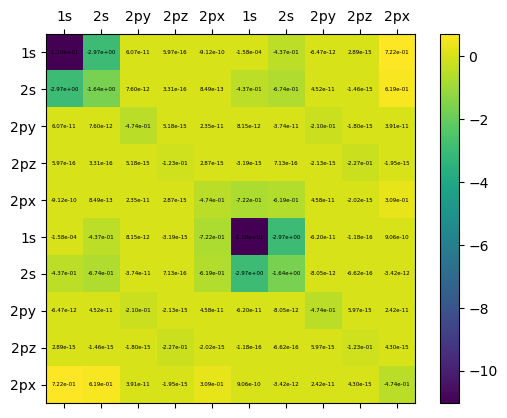

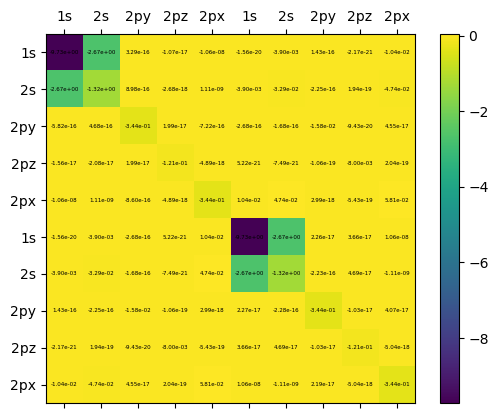

In [511]:
from mlelec.utils.plot_utils import plot_hamiltonian
fig, ax, im = plot_hamiltonian(HT_pyscf[0][0,0,0])
fig.colorbar(im, ax = ax)
fig, ax, im = plot_hamiltonian(HT_cp2k[0][0,0,0])
fig.colorbar(im, ax = ax)

In [458]:
def print_matrix(matrix):
    for row in matrix:
        for v in row:
            print(f'{v:>15.10f}', end = '  ')
        print()

In [805]:
target_coupled_blocks.keys

Labels(
    block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
        1           6       1    0       6       1    0   0
        -1          6       1    0       6       1    0   0
        1           6       1    0       6       2    0   0
        -1          6       1    0       6       2    0   0
        1           6       1    0       6       2    1   1
        -1          6       1    0       6       2    1   1
        1           6       2    0       6       1    0   0
        -1          6       2    0       6       1    0   0
        1           6       2    0       6       2    0   0
        -1          6       2    0       6       2    0   0
        1           6       2    0       6       2    1   1
        -1          6       2    0       6       2    1   1
        1           6       2    1       6       1    0   1
        -1          6       2    1       6       1    0   1
        1           6       2    1       6       2    0   1
        -1          6       2   

In [1052]:
for k, b in pred.items(): #target_coupled_blocks.items():
    
    from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
    featk = map_targetkeys_to_featkeys(hfeat, k, return_key=True)
    feat = map_targetkeys_to_featkeys(hfeat, k)
    L = k['L']
    btype = k['block_type']
    s = featk['inversion_sigma'][0]
    
    idx = np.where(np.all(b.samples.values[:, 3:] == 0, axis = 1))[0]
    idxf = np.where(np.all(feat.samples.values[:, 3:] == 0, axis = 1))[0]

    if btype != 0:
    # if True:
        diff = torch.norm(b.values[idx][0] - btype * b.values[idx][1])
        summ = torch.norm(b.values[idx][0] + btype * b.values[idx][1])
        difff = torch.norm(feat.values[idxf][0] - btype * feat.values[idxf][1])
        summf = torch.norm(feat.values[idxf][0] + btype * feat.values[idxf][1])
        # diff = torch.norm(b.values[idx][0] - b.values[idx][1])
        # summ = torch.norm(b.values[idx][0] + b.values[idx][1])
        if diff>1e-25:
            print('t',k.values,'{:.3e} {:.3e} {:.3e} {:.3e} | {:.3e} {:.3e} {:.3e} {:.3e}'.format(diff.item(),summ.item(),torch.norm(b.values[idx][0]).item(), torch.norm(b.values[idx][1]).item(), 
                                                                                                  difff.item(),summf.item(),torch.norm(feat.values[idxf][0]).item(), torch.norm(feat.values[idxf][1]).item()))
        if difff>1e-19 :
            print('f',featk.values,difff.item(),summf.item(),torch.norm(feat.values[idxf][0]).item(), torch.norm(feat.values[idxf][1]).item())

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [786]:
torch.norm(hfeat[10].values[47] + hfeat[10].values[30])
for k, b in hfeat.items():
    L = k['spherical_harmonics_l']
    btype = k['block_type']
    s = k['inversion_sigma']
    idx = np.where(np.all(b.samples.values[:, 3:] == 0, axis = 1))[0]
    if btype != 0:
    # if True:
        diff = torch.norm(b.values[idx][0] - (-1)**(L)*(s) * b.values[idx][1])
        summ = torch.norm(b.values[idx][0] + (-1)**(L)*(s) * b.values[idx][1])
        # diff = torch.norm(b.values[idx][0] - b.values[idx][1])
        # summ = torch.norm(b.values[idx][0] + b.values[idx][1])
        if diff>1e-19 :
            print(k,diff,summ,torch.norm(b.values[idx][0]), torch.norm(b.values[idx][1]))


    # else:
    #     diff = torch.norm(b.values[idx][0] -  b.values[idx][1])
        
    #     assert diff<1e-10, (diff, torch.norm(b.values[idx][0]) , torch.norm(b.values[idx][1]))
        

LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=-1) tensor(5.3023e-16) tensor(0.) tensor(2.6511e-16) tensor(2.6511e-16)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=1) tensor(8.8035e-16) tensor(0.) tensor(4.4017e-16) tensor(4.4017e-16)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=-1) tensor(1.2788e-15) tensor(0.) tensor(6.3940e-16) tensor(6.3940e-16)
LabelsEntry(order_nu=3, inversion_sigma=1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=1) tensor(1.3486e-15) tensor(0.) tensor(6.7431e-16) tensor(6.7431e-16)
LabelsEntry(order_nu=3, inversion_sigma=-1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=-1) tensor(4.2846e-17) tensor(0.) tensor(2.1423e-17) tensor(2.1423e-17)
LabelsEntry(order_nu=3, inversion_sigma=-1, spherical_ha

In [772]:
torch.norm(b.values[idx][0] + b.values[idx][1])

tensor(9.4019)

# Targets

In [104]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis_OLD, _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks_OLD, matrix_to_blocks

# def get_targets_OLD(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
#     # if target.lower() == 'fock':
#     #     matrices_negative = dataset._fock_realspace_negative_translations
#     # elif target.lower() == 'overlap':
#     #     matrices_negative = dataset._overlap_realspace_negative_translations
#     # else: 
#     #     raise ValueError('target must be fock or overlap')
#     # blocks = matrix_to_blocks(dataset, matrices_negative , device = device, cutoff = cutoff, all_pairs = all_pairs, target= target)
#     blocks = matrix_to_blocks_OLD(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target)
#     coupled_blocks = _to_coupled_basis_OLD(blocks, skip_symmetry = True, device = device, translations = True)

#     blocks = blocks.keys_to_samples('cell_shift_a')
#     blocks = blocks.keys_to_samples('cell_shift_b')
#     blocks = blocks.keys_to_samples('cell_shift_c')

#     coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
#     coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
#     coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
#     return blocks , coupled_blocks

def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    return blocks , coupled_blocks

In [107]:
from metatensor import sort
cutoff = 3
print('True')
tb_T, tcb_T = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True)
print()
print('False')
tb_F, tcb_F = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)

True
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
2 (-1, -1, 0) 0 1
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 0
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 0 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
3 (-1, 0, 0) 1 1
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 0
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 0 1
4 (-1, 1, 0) 1 0
4 (-1, 1, 0) 1 0
4 (-1, 1, 0) 1 0
4 (-1, 1, 0) 1 0


# ISSUE
If `all_pairs == False`, some negative translations are skipped because `i > j`. Instead, we would like to keep the upper triangle of every `H[T]`.
There are some subtleties when skipping samples that we are missing.

In [78]:
for k in tcb_F.keys:
    print(f"{k['n_i']}{k['l_i']}-{k['n_j']}{k['l_j']}  {k['L']} {k['block_type']}")

10-10  0 1
10-10  0 -1
10-20  0 1
10-20  0 -1
10-21  1 1
10-21  1 -1
20-20  0 1
20-20  0 -1
20-21  1 1
20-21  1 -1
21-21  0 1
21-21  1 1
21-21  2 1
21-21  0 -1
21-21  1 -1
21-21  2 -1
10-10  0 0
10-20  0 0
10-21  1 0
20-20  0 0
20-21  1 0
21-21  0 0
21-21  1 0
21-21  2 0


In [82]:
for kT, bT in tcb_F.items():
    sT = np.unique(bT.samples.view(['cell_shift_a', 'cell_shift_b', 'cell_shift_c']).values.tolist(),
          axis=0)
    
    print(sT.shape)
print()

for kF, bF in tcb_Fn.items():
    sF = np.unique(bF.samples.view(['cell_shift_a', 'cell_shift_b', 'cell_shift_c']).values.tolist(),
          axis=0)
    print(sF.shape)
print()

(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)

(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)



In [89]:
for (k1, b1), (k2, b2) in zip(tcb_T.items(), tcb_Tn.items()):
    print(b1.samples.values==b2.samples.values)
    print()
    # assert torch.norm(b1.values-b2.values) < 1e-15, torch.norm(b1.values-b2.values)


[[ True  True False  True False  True]
 [ True  True  True  True False  True]
 [ True  True False False False  True]
 [ True False False False False  True]
 [ True  True  True False False  True]
 [ True  True False False False  True]
 [ True False False  True False  True]
 [ True False  True  True False  True]
 [ True  True False False False  True]
 [ True  True  True  True  True  True]
 [ True False  True  True False  True]
 [ True  True  True False False  True]
 [ True  True  True False False  True]
 [ True False  True  True False  True]
 [ True  True  True  True  True  True]
 [ True  True False False False  True]
 [ True False  True  True False  True]
 [ True False False  True False  True]
 [ True  True False False False  True]
 [ True  True  True False False  True]
 [ True False False False False  True]
 [ True  True False False False  True]
 [ True  True  True  True False  True]
 [ True  True False  True False  True]]

[[ True  True False  True False  True]
 [ True  True  True  Tr

In [30]:
from mlelec.utils.pbc_utils import blocks_to_matrix
H = blocks_to_matrix(target_coupled_blocks, dataset)
len(H[0].keys())


27

23

In [22]:
for T in H[0]:
    mT = tuple(-t for t in T)
    print(T, torch.norm(H[0][T]-H[0][mT].T).item())

(-3, 1, 0) 1.3010816401291942e-16
(-2, -1, 0) 1.8152674677908653e-16
(-2, 0, 0) 7.257853609099148e-16
(-2, 1, 0) 3.7865371116308136e-16
(-2, 2, 0) 2.7815145345585707e-16
(-1, -2, 0) 1.8934322216558335e-16
(-1, -1, 0) 3.208491784565099e-16
(-1, 0, 0) 4.0566684514300965e-16
(-1, 1, 0) 2.8618463727818928e-16
(-1, 2, 0) 2.7596340908427604e-16
(-1, 3, 0) 1.357074218475278e-16
(0, -2, 0) 3.9871198579781764e-16
(0, -1, 0) 6.619280043065567e-16
(0, 0, 0) 7.75967898313631e-20
(0, 1, 0) 6.619280043065567e-16
(0, 2, 0) 3.9871198579781764e-16
(1, -3, 0) 1.357074218475278e-16
(1, -2, 0) 2.7596340908427604e-16
(1, -1, 0) 2.8618463727818928e-16
(1, 0, 0) 4.0566684514300965e-16
(1, 1, 0) 3.208491784565099e-16
(1, 2, 0) 1.8934322216558335e-16
(2, -2, 0) 2.7815145345585707e-16
(2, -1, 0) 3.7865371116308136e-16
(2, 0, 0) 7.257853609099148e-16
(2, 1, 0) 1.8152674677908653e-16
(3, -1, 0) 1.3010816401291942e-16


# Features

In [1057]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features

hypers_pair = {'cutoff': cutoff,
               'max_radial': 6,
               'max_angular': 6,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 6,
               'max_angular': 6,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = True
all_pairs = False
LCUT = 3

# rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
#                       kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
#                       T_dict = dataset._translation_dict)

def compute_features(dataset):
    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = None, 
                          T_dict = None)

    # rhoij_blocks = []
    # for k, b in rhoij.items():
    #     values = []
    #     samples = []
    #     for iss, s in enumerate(b.samples):
    #         if s['cell_shift_a'] == 0 and s['cell_shift_b'] == 0 and s['cell_shift_c'] == 0 and s['sign'] == 1:
    #             values.append(b.values[iss])
    #             samples.append(s.values[:-4])
    #     rhoij_blocks.append(TensorBlock(samples = Labels(b.samples.names[:-4], np.array(samples)),
    #                                     components = b.components,
    #                                     properties = b.properties,
    #                                     values = torch.from_numpy(np.array(values))))
    # rhoij = TensorMap(rhoij.keys, rhoij_blocks)
    
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)
    # hfeat = twocenter_hermitian_features(single_center = rhonui, pair = rhoij)
    # hfeat = hfeat.keys_to_samples('cell_shift_a')
    # hfeat = hfeat.keys_to_samples('cell_shift_b')
    # hfeat = hfeat.keys_to_samples('cell_shift_c')
    return hfeat

In [1058]:
hfeat = compute_features(dataset)

{'cutoff': 6, 'max_radial': 6, 'max_angular': 6, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
torch.Size([92, 1, 6]) 1
torch.Size([182, 1, 6]) 2
torch.Size([92, 3, 6]) 1
torch.Size([182, 3, 6]) 2
torch.Size([92, 5, 6]) 1
torch.Size([182, 5, 6]) 2
torch.Size([92, 7, 6]) 1
torch.Size([182, 7, 6]) 2
torch.Size([92, 9, 6]) 1
torch.Size([182, 9, 6]) 2
torch.Size([92, 11, 6]) 1
torch.Size([182, 11, 6]) 2
torch.Size([92, 13, 6]) 1
torch.Size([182, 13, 6]) 2


In [1039]:
hfeat[10].samples

Labels(
    structure  center  neighbor  cell_shift_a  cell_shift_b  cell_shift_c
        0        0        1           0             0             0
)

In [1042]:
zero_blocks = []
for k, b in target_coupled_blocks.items():
    values = []
    samples = []
    for iss, s in enumerate(b.samples):
        if s['cell_shift_a'] == 0 and s['cell_shift_b'] == 0 and s['cell_shift_c'] == 0 and s['neighbor']>=s['center']:
            values.append(b.values[iss])
            samples.append(s.values[:-3])
    zero_blocks.append(TensorBlock(samples = Labels(b.samples.names[:-3], np.array(samples)),
                                    components = b.components,
                                    properties = b.properties,
                                    values = torch.from_numpy(np.array(values))))
zero_target = TensorMap(target_coupled_blocks.keys, zero_blocks)

In [1043]:
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = zero_target,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 128, 
                            nlayers = 1,
                            train_kspace = False)

model = model.double()
for p, (_, b) in zip(model.parameters(), zero_target.items()):
    p.data = torch.ones_like(p.data)

In [1046]:
pred = model()

In [350]:
from mlelec.features.acdc_utils import _pca
hfeat_pca = _pca(hfeat, npca = 0.9)

tensor([1., 1.])
tensor([0.4665, 0.8548, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([0.4358, 0.8211, 0.9173, 0.9861, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
tensor([0.4289, 0.7018, 0.8741, 0.9439, 0.9720, 0.9937, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([0.5079, 0.8333, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([0.6576, 0.8812, 0.9703, 0.9941, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
tensor([0.4153, 0.7486, 0.8929, 0.9458, 0.9862, 0.9996, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1., 1.])
tensor([0.1797, 0.3199, 0.4278, 0.5024, 0.5629, 0.6232, 0.6793, 0.7279, 0.7724,
        0.8124, 0.8415, 0.8648, 0.8829, 0.9010, 0.9174, 0.9323, 0.9437, 0.9527,
        0.9615, 0.9700, 0.9757, 0.9811, 0.9852, 0.9885, 0.9914, 0.9939, 0.9961,
        0.9976, 0.9984, 0.9990, 0.9995, 0.9998, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,


# Train

## Ridge regression

In [311]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [516]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [1059]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(3.5485e-20)


In [401]:
for r in ridges_bias:
    print(r.alpha_)

3.2745491628777315e-15
2.656087782946695e-12
1.6297508346206402e-13
1e-06
3.2745491628777315e-15
2.656087782946695e-12
1.6297508346206402e-13
3.053855508833412e-14
3.5111917342151416e-08
5.72236765935022e-15
1e-06
3.2745491628777315e-15
3.5111917342151416e-08
5.72236765935022e-15
5.3366992312063014e-14
3.053855508833412e-14
3.5111917342151416e-08
5.336699231206302e-30
1.873817422860387e-23
3.764935806792487e-17
1e-30
4.3287612810830615e-27
2.477076355991714e-19
3.764935806792487e-17
2.477076355991714e-19
4.03701725859655e-26
1e-14


## Torch

In [518]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [519]:
from mlelec.models.linear import LinearModelPeriodic

In [539]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
target_kspace = dataset.fock_kspace #orch.stack([kfock[ifr][:1] for ifr in range(3)])
CG = ClebschGordanReal(lmax = 3, device = device)

In [1060]:
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 128, 
                            nlayers = 1,
                            train_kspace = False)

model = model.double()
for p, (_, b) in zip(model.parameters(), target_coupled_blocks.items()):
    p.data = torch.ones_like(p.data)

losses = {}
para = {}
grad = {}
learning_rates = {}
nepoch = 5000

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=1e-1)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-2))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 80, verbose=True))
    # schedulers.append(torch.optim.lr_scheduler.MultiStepLR(optimizers[-1], milestones=[2000, 4000, 6000, 8000], gamma=1e-1, verbose = False))
    

In [715]:
kpts_train = [dataset_cp2k.kpts_rel[ifr][:] for ifr in range(len(dataset_cp2k.structures))]

nk = len(kpts_train[0])
target_kspace = [x[:nk] for x in dataset_cp2k.fock_kspace]

In [716]:
seed = 1
np.random.seed(seed)
kpts_ = torch.from_numpy(np.array(kpts_train)).to(device)

# nepoch = 10000

new_sched = True
# epoch = 2000
for epoch in range(nepoch):
    # epoch = epoch_+2000
    
    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    # optimizer.zero_grad()
    
    # epoch_loss = 0
    pred = model()
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 1000:
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)
        epoch_loss = epoch_loss.item()
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            # torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
            optimizers[ik].step()
            # schedulers[ik].step()
            schedulers[ik].step(loss)
            
        # epoch_loss += tot_loss
            if key not in losses:
                losses[key] = [loss.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
            
    
        # for ik, (key, loss) in enumerate(model.model):
        
    else:
        if new_sched:
            pred_before_k = pred.copy()

            optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-2)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 200, verbose=True)
            # for s, o in zip(schedulers, optimizers):
            #     s = torch.optim.lr_scheduler.ReduceLROnPlateau(o, factor = 0.5, patience = 100, verbose=True)
            new_sched = False
        
        loss = L2_kspace_loss(pred, 
                              target_kspace, 
                              dataset, 
                              cg = CG, 
                              kpts = kpts_,
                              norm = 1
                              )

        loss.backward(retain_graph = False)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        epoch_loss = loss.item()
        for key in model.model:
            if key not in losses:
                losses[key] = [epoch_loss/len(model.model)]
            else:
                losses[key].append(epoch_loss/len(model.model))
    
        # for ik, key in enumerate(model.model):
        #     optimizers[ik].step()
        #     schedulers[ik].step(epoch_loss)
        
        optimizer.step()
        scheduler.step(epoch_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

        # for i, key in enumerate(model.model):
        #     if key not in para:
        #         para[key] = []
        #         grad[key] = []
        #         # optimizers[0].param_groups[0]['lr']
        #     for param in model.model[key].parameters():
        #         grad[key].append(param.grad.norm().item())
        #         para[key].append(param.norm().item())

    #     # validate 
    #     valpred = model.predict(hfeat_test, target_test)
    #     if loss_func == 'kspace':
    #         val_loss = L2_kspace_loss(valpred, target_test, dataset)
    #     else:
    #         val_loss = L2_loss(valpred, target_test)
        
    #     print(f"Epoch {epoch} val loss {val_loss}")


Epoch       0, train loss on all blocks  245.1297167999, train loss per prediction 3.96370e-03
Epoch      10, train loss on all blocks   37.8084094544, train loss per prediction 1.55667e-03
Epoch      20, train loss on all blocks   22.8042988526, train loss per prediction 1.20896e-03
Epoch      30, train loss on all blocks   20.5898861092, train loss per prediction 1.14876e-03
Epoch      40, train loss on all blocks   16.0823873216, train loss per prediction 1.01526e-03
Epoch      50, train loss on all blocks   15.3475891705, train loss per prediction 9.91797e-04
Epoch      60, train loss on all blocks   15.4306145692, train loss per prediction 9.94476e-04
Epoch      70, train loss on all blocks   15.3221518753, train loss per prediction 9.90975e-04
Epoch      80, train loss on all blocks   15.2618134874, train loss per prediction 9.89022e-04
Epoch 00082: reducing learning rate of group 0 to 8.0000e-03.
Epoch 00082: reducing learning rate of group 0 to 8.0000e-03.
Epoch 00082: reducing

KeyboardInterrupt: 

In [478]:
for _, b in target_coupled_blocks.items():
    print(b.values.norm())

tensor(8.0026e-05)
tensor(1.6948e-15)
tensor(0.2936)
tensor(1.5323e-07)
tensor(5.8327e-06)
tensor(0.4957)
tensor(0.2936)
tensor(1.5323e-07)
tensor(1.0472)
tensor(1.5566e-16)
tensor(0.0112)
tensor(1.0385)
tensor(5.8327e-06)
tensor(0.4957)
tensor(0.0112)
tensor(1.0385)
tensor(0.2373)
tensor(4.1756e-16)
tensor(1.0598)
tensor(1.1336e-16)
tensor(0.0268)
tensor(2.9054e-16)
tensor(18.0589)
tensor(0.8759)
tensor(3.4130e-05)
tensor(0.8759)
tensor(0.7087)
tensor(3.8052e-08)
tensor(3.4130e-05)
tensor(3.8052e-08)
tensor(0.5480)
tensor(1.1259e-16)
tensor(0.1790)


In [227]:
pred = model()
losses, _ = L2_loss(pred, target_coupled_blocks, loss_per_block = True)
for l, key in zip(losses, model.model):
    print(f'{l.item():10.3f}', key)

     0.000 (1, 6, 1, 0, 6, 1, 0, 0)
     0.000 (-1, 6, 1, 0, 6, 1, 0, 0)
     0.014 (1, 6, 1, 0, 6, 2, 0, 0)
     0.000 (-1, 6, 1, 0, 6, 2, 0, 0)
     0.000 (1, 6, 1, 0, 6, 2, 1, 1)
     0.103 (-1, 6, 1, 0, 6, 2, 1, 1)
     0.014 (1, 6, 2, 0, 6, 1, 0, 0)
     0.000 (-1, 6, 2, 0, 6, 1, 0, 0)
     0.120 (1, 6, 2, 0, 6, 2, 0, 0)
     0.000 (-1, 6, 2, 0, 6, 2, 0, 0)
     0.007 (1, 6, 2, 0, 6, 2, 1, 1)
     0.241 (-1, 6, 2, 0, 6, 2, 1, 1)
     0.000 (1, 6, 2, 1, 6, 1, 0, 1)
     0.104 (-1, 6, 2, 1, 6, 1, 0, 1)
     0.000 (1, 6, 2, 1, 6, 2, 0, 1)
     0.242 (-1, 6, 2, 1, 6, 2, 0, 1)
     0.015 (1, 6, 2, 1, 6, 2, 1, 0)
     0.000 (1, 6, 2, 1, 6, 2, 1, 1)
     1.452 (1, 6, 2, 1, 6, 2, 1, 2)
     0.000 (-1, 6, 2, 1, 6, 2, 1, 0)
     0.000 (-1, 6, 2, 1, 6, 2, 1, 1)
     0.000 (-1, 6, 2, 1, 6, 2, 1, 2)
     0.012 (0, 6, 1, 0, 6, 1, 0, 0)
     0.000 (0, 6, 1, 0, 6, 2, 0, 0)
     0.000 (0, 6, 1, 0, 6, 2, 1, 1)
     0.000 (0, 6, 2, 0, 6, 1, 0, 0)
     0.000 (0, 6, 2, 0, 6, 2, 0, 0)
     0.000 (0, 6,

In [165]:
loss_k = L2_kspace_loss(pred, target_kspace, dataset, cg = CG, kpts = kpts_, norm = 1)

In [166]:
losses, loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)

In [169]:
print(loss.item(), loss_k/225)

359.6911604459602 tensor(356.1006, grad_fn=<DivBackward0>)


Text(0, 0.5, 'loss')

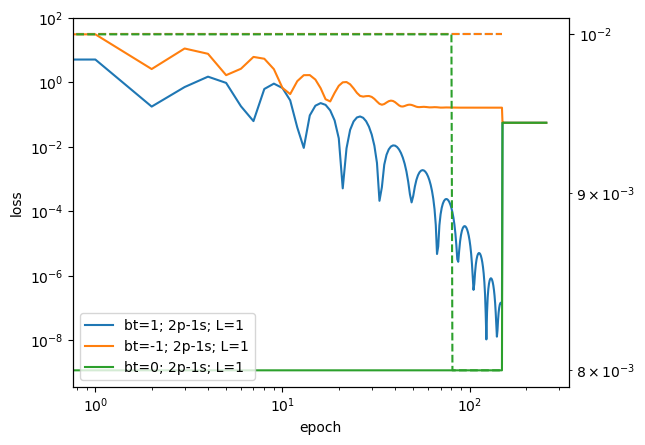

In [476]:
o = {0: 's', 1: 'p'}

fig, ax = plt.subplots()
ax_lr = ax.twinx()
for key in losses:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if n1 == 2 and l1 == 1 and n2 == 1 and l2 == 0: # and L == 0:
    # if True:
        y = []
        for l in losses[key]:
            try:
                y.append(l.detach().numpy())
            except AttributeError:
                y.append(l)
        pl, = ax.loglog(np.arange(len(losses[key])), y, '-', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
        ax_lr.loglog(np.arange(len(learning_rates[key])), learning_rates[key], '--', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}', color = pl.get_color())
ax.legend(loc = 'lower left')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
# ax_lr.set_ylabel('learning rate')

In [82]:
from mlelec.utils.pbc_utils import blocks_to_matrix

In [450]:
len(blocks_to_matrix(pred_before_k, dataset)[0])

51

In [451]:
len(blocks_to_matrix(pred, dataset)[0])

51

In [419]:
def reconstruct(pred, dataset, cutoff):
    from mlelec.utils.pbc_utils import inverse_bloch_sum
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    S = [inverse_bloch_sum(dataset, dataset.overlap_kspace[ifr], ifr, cutoff) for ifr in range(len(dataset.structures))]
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in S[ifr]:
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in S[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                print(T)
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [428]:
rH_r, rS_r = reconstruct(pred_before_k, dataset, cutoff = cutoff)
rH_k, rS_k = reconstruct(pred, dataset, cutoff = cutoff)

_, true_target_coupled_blocks = get_targets(dataset, cutoff = 12, device = device)
rH_true, rS_true = reconstruct(true_target_coupled_blocks, dataset, cutoff = 12)

-0.028305136685196606
-0.021417732574609973
-0.01988472493184316


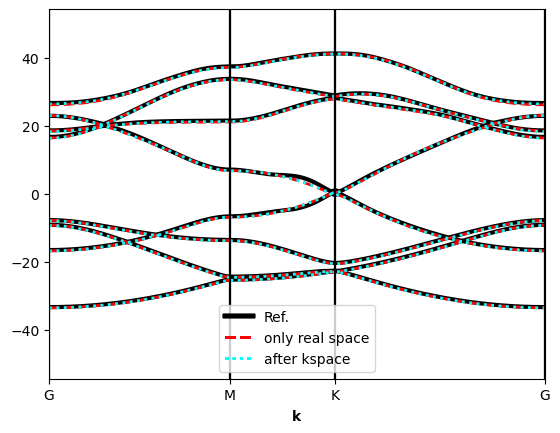

In [429]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(rH_true[0].values())) #np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(rS_true[0].values())) #np.asarray(list(dataset.overlap_realspace[0].values()))
R_vec_rel = [list(T) for T in rH_true[0]]

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', 
                                  factor = 1,
                                  kpath = kpath, ax = ax, color = 'k', R_vec_rel_in = R_vec_rel, lw = 3)
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_r, rH_k], [rS_r, rS_k], ['red', 'cyan'], ['--', ':'], [1, 1], ['only real space', 'after kspace']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):
    # if label == 'only real space':
    #     continue
    realfock_cutoff = np.asarray(list(H[0].values()))
    realover_cutoff = np.asarray(list(S[0].values()))
    R_vec_rel = [list(T) for T in H[0]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh, 
                                      factor = factor,
                                      lw = 2,
                                      R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# ax.set_ylim(-35, 43)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



(1900, 2500)

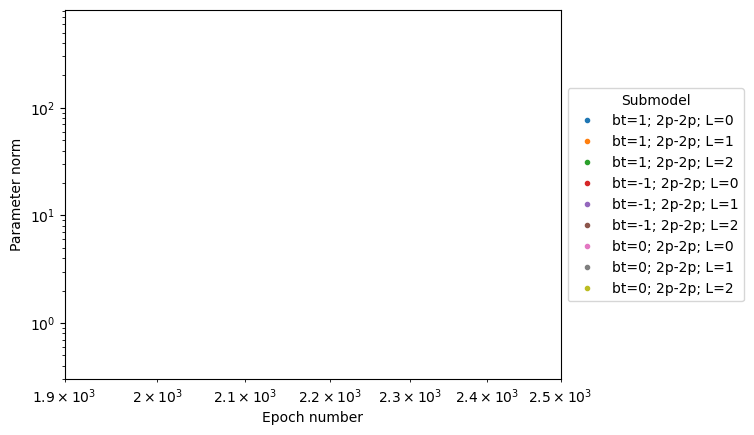

In [385]:
o = {0: 's', 1: 'p'}

fig, ax = plt.subplots()

for key in para:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if n1 == 2 and l1 == 1 and n2 == 2 and l2 == 1:
        ax.loglog(np.arange(len(para[key]))*10, para[key], '.', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(title = 'Submodel', loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Parameter norm')
ax.set_xlim(1900, 2500)

Text(0, 0.5, 'Gradient norm')

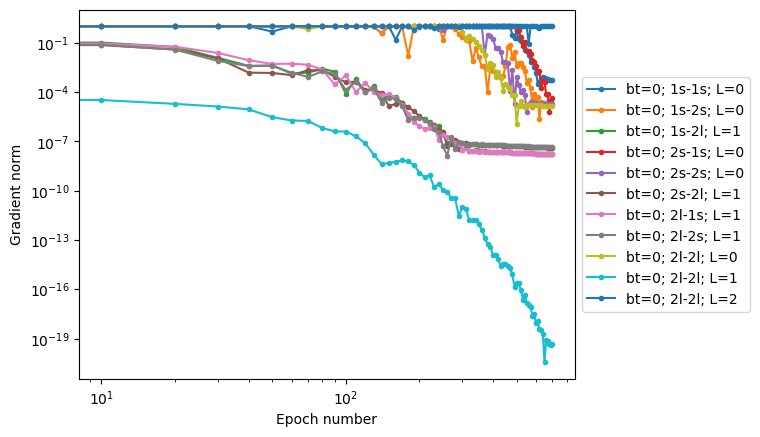

In [413]:
o = {0: 's', 1: 'l'}

fig, ax = plt.subplots()

for key in grad:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if bt == 0:
        ax.loglog(np.arange(len(grad[key]))*10, grad[key], '.-', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Gradient norm')
# ax.set_xlim(800)


# TODO: build model for 1s-1s interaction

In [179]:
weights = {}
for i, p in enumerate(model.parameters()):
    # if i//2 not in weights:
        # weights[i//2] = {}
        # weights[i//2][0] = p.data
    # else:
        # weights[i//2][1] = p.data
    weights[i] = p.data

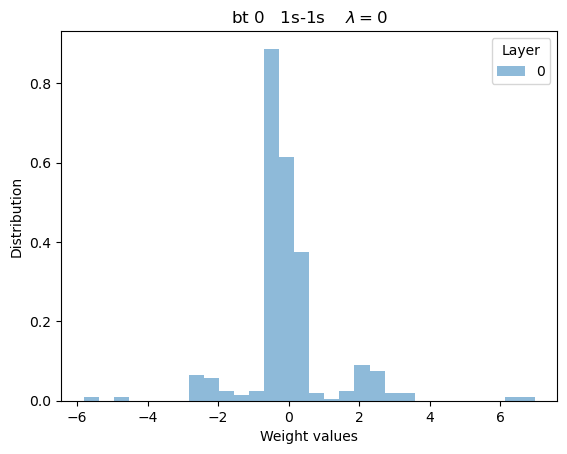

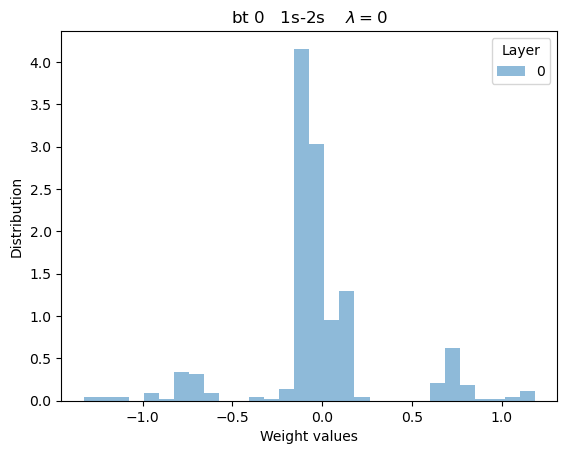

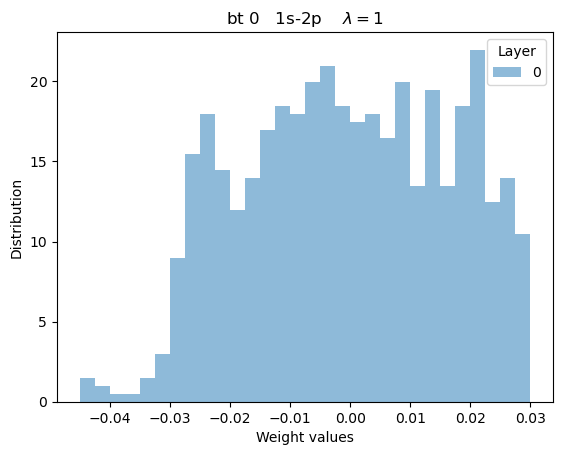

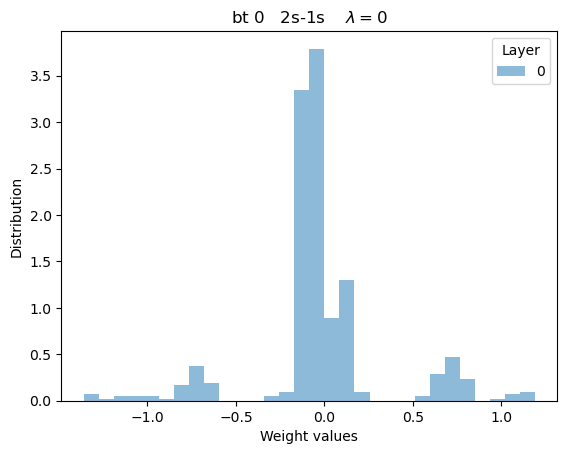

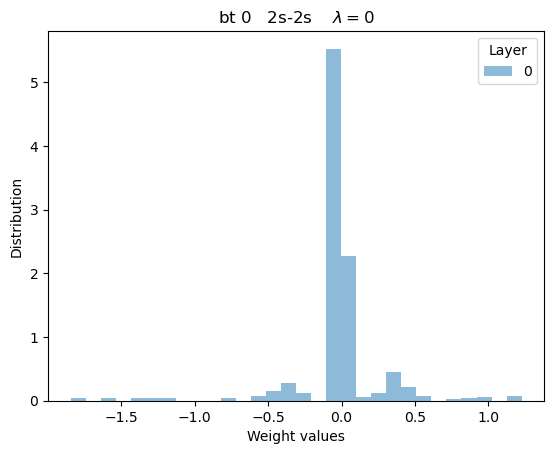

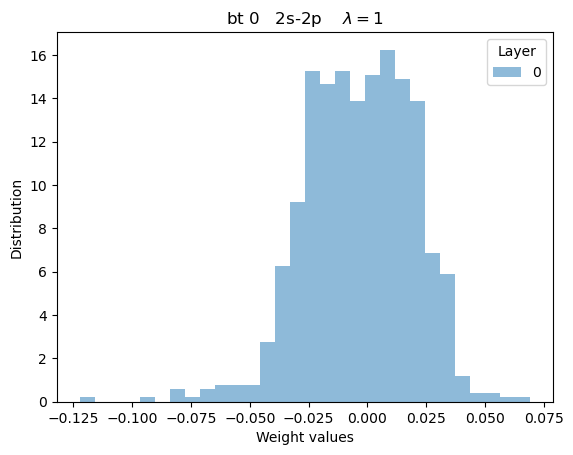

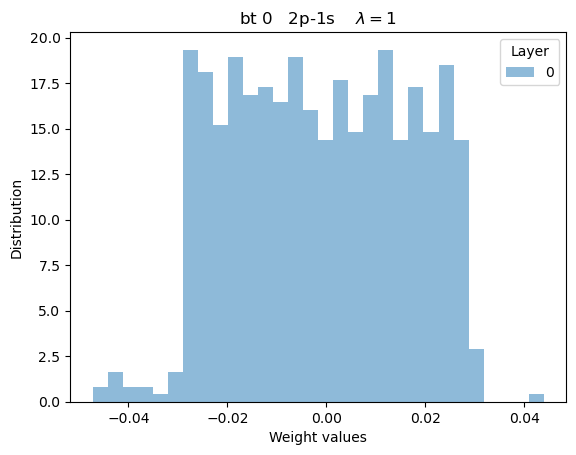

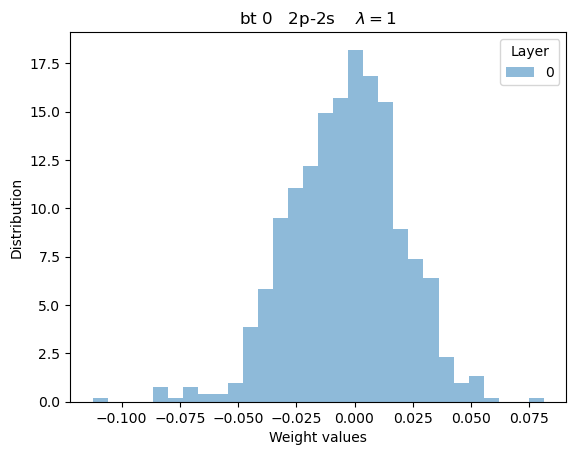

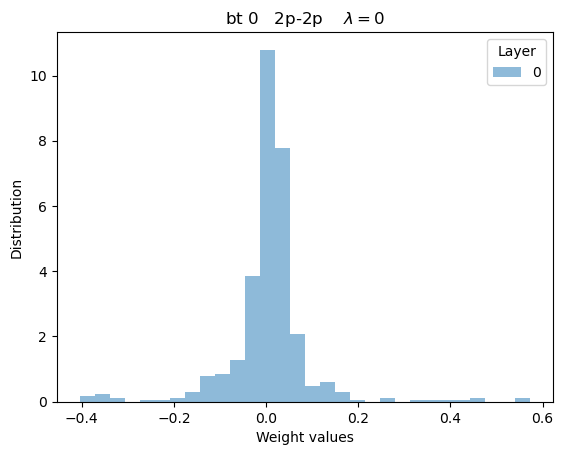

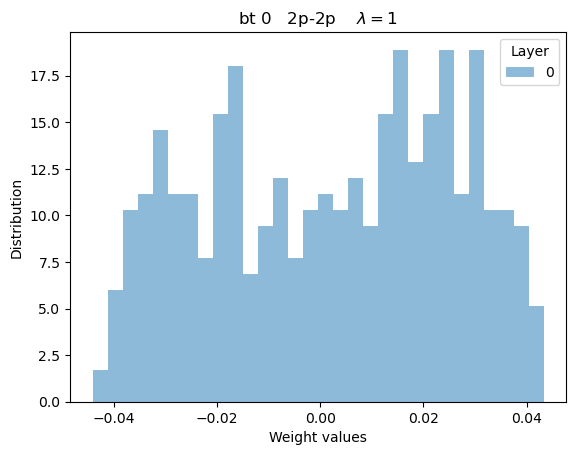

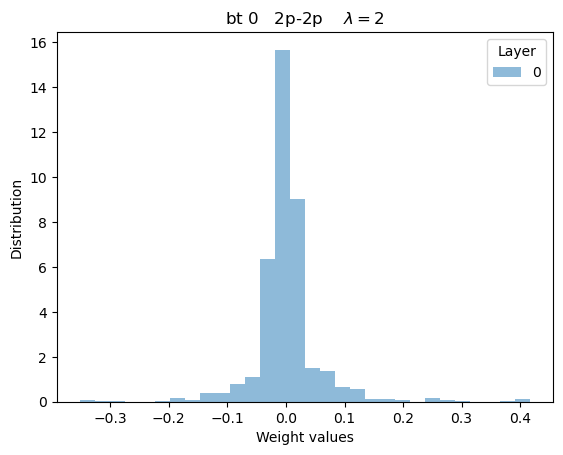

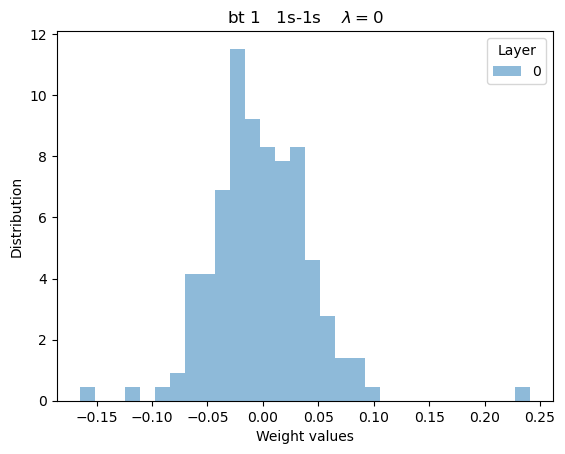

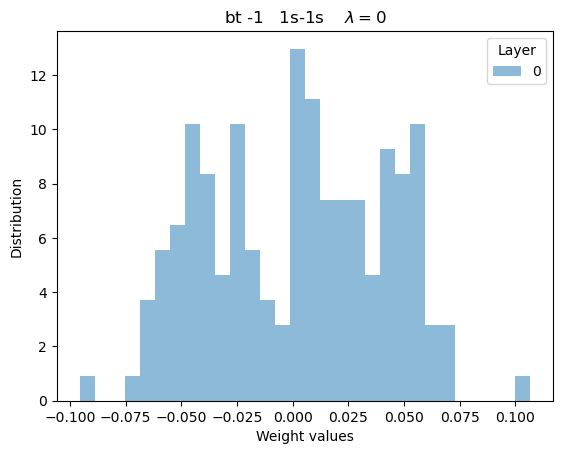

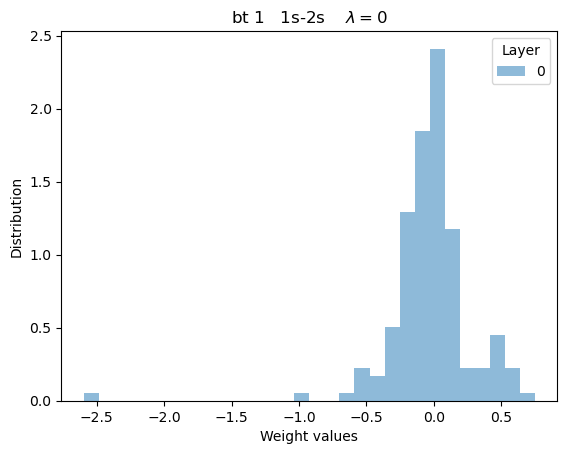

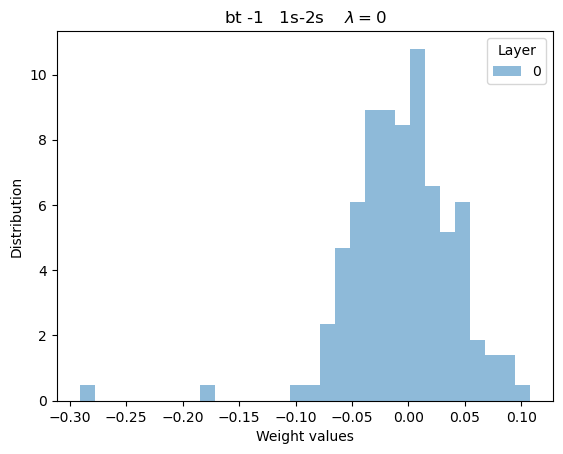

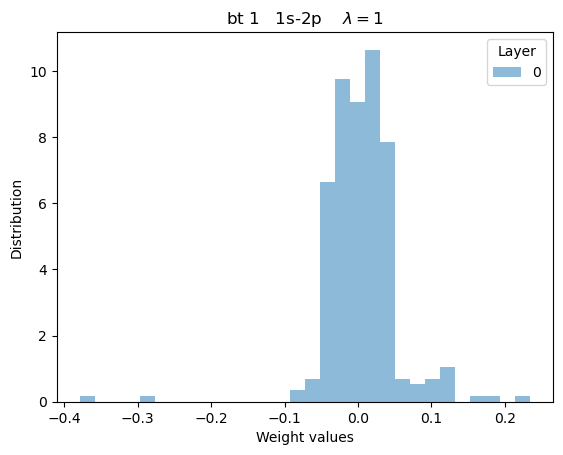

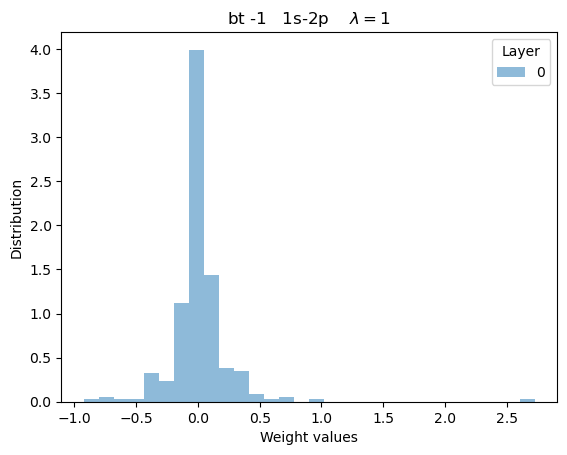

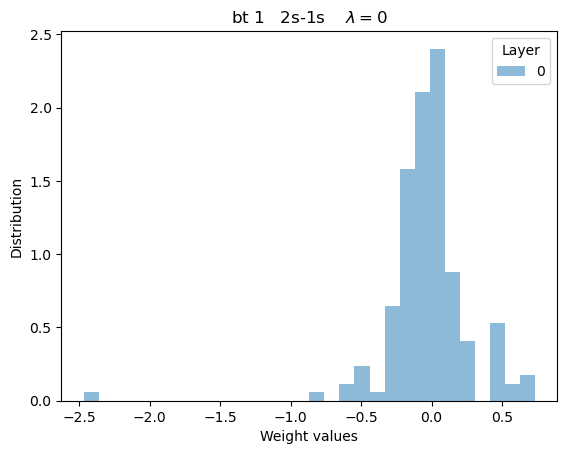

In [180]:
orb_labels = {0: 's', 1: 'p', 2: 'd'}
for i in range(18):
    fig, ax = plt.subplots()
    bt, _, n0, l0, _, n1, l1, L = pred.keys[i].values
    title = f'bt {bt}   {n0}{orb_labels[l0]}-{n1}{orb_labels[l1]}    $\lambda={L}$'
    # for j in range(1):
        # ax.hist(weights[i][j].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.hist(weights[i].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.set_title(title)
    ax.legend(title='Layer')
    ax.set_xlabel('Weight values')
    ax.set_ylabel('Distribution')

In [47]:
for k, b in hfeat.items():
    print()
    print(k)
    for sample in b.values:
        print('{:.3f} {:.3f}'.format(torch.norm(sample).item(), torch.var(sample).item()))


LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=0)
3.234 0.017
3.234 0.017

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.157 0.000
0.157 0.000

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
4.121 0.003
4.121 0.003

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
3.600 0.002
3.600 0.002

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.004 0.000
0.004 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
0.101 0.000
0.101 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
0.149 

In [51]:
target_kspace[0].shape

torch.Size([64, 10, 10])

In [71]:
for k, b in target_coupled_blocks.items():
    print()
    print(k)
    # for sample in b.values:
    #     print('{:.3e} {:.3e}'.format(torch.norm(sample).item(), torch.var(sample).item()))
    # print(np.mean([torch.norm(feature).item() for feature in b.values]), np.std([torch.norm(sample).item() for sample in b.values]))
    print('{:.3e} {:.3e}'.format(torch.norm(b.values, dim = 2).mean().item(), torch.norm(b.values, dim = 2).std().item()))


LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
1.102e+01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
1.733e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=1, l_j=0, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=0, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=1, L=0)
7.948e-01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2,

In [70]:
b.values.norm(dim=2).mean(dim=0)

tensor([3.2785e-11, 4.8314e-13, 1.6071e-16, 1.6817e-12, 1.4629e-16],
       device='cuda:0')

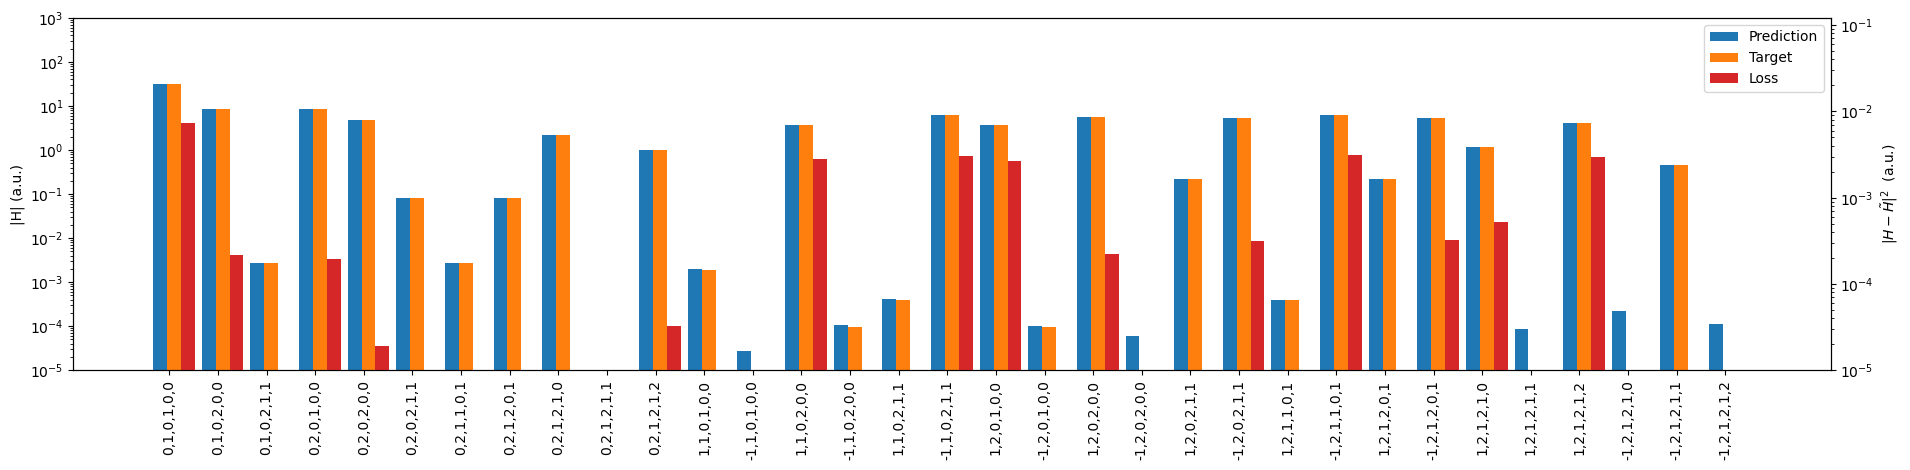

In [156]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks_c, pred_before_k, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()